In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

We will first try with the usual convex broken power law:

In [3]:
def br_po_lw(xdata, E1, fl_0, lam1, sqrtdelta_lam12):
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return polw

Now let's add the $\chi^2$ to the function in order to minimize:

In [4]:
def br_po_lw_chsq(params): 
    #you need to define theE, SED and SED_u before(E and SED must be a numpy.array and SED an scalar or a numpy.array)
    E1, fl_0, lam1, sqrtdelta_lam12 = params
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return np.sum(np.square(ydata - polw) / np.square(ydata_u))

As we will do a multiple broken power law, from now on the position of the knots will not be a free parameter anymore in order to make the convergence of the fit easier.

In [5]:
def multiple_bpl(xdata, params):
    if knots < 3 or knots > 30: #change this when adding more number of knots
        raise Exception('knots have to be larger or equal than 3 and smaller than 30')
    else:
        polw = np.zeros(len(xdata))
        Es = np.geomspace(xdata[0], xdata[-1], knots)
        lam = np.zeros(knots-1)
        phi = np.zeros(knots-1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        lam0 = params[1]
        sqrtdelta_lam = params[2:knots]
        lam[0] = lam0
        phi[0] = phi_0
        for i in range(1, knots-1):
            lam[i] = lam[i-1] + (sqrtdelta_lam[i-1]) ** 2
            phi[i] = phi[i-1] * ((Es[i]/Es[i-1]) ** (-lam[i-1]))
        for i in range(knots-1):
            for j in range(len(xdata)):
                if Es[i] < xdata[j] <= Es[i+1]:
                    polw[j] = phi[i] * ((xdata[j] / Es[i]) ** (-lam[i]))
                elif xdata[j] <= Es[1]:
                    polw[j] = phi[0] * ((xdata[j] / Es[0]) ** (-lam[0]))
                elif xdata[j] > Es[-1]:
                    polw[j] = phi[-2] * ((xdata[j] / Es[-2]) ** (-lam[-2]))
    return polw


In [6]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

Now we define the function of the fit

In [7]:
def multiple_bpl_fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

Let's check that the program works as intended

In [8]:
file = np.loadtxt('tau_dominguez11.out')

pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)
SED = np.square(E) * dNdEa
SED_u = SED * 0.1

In [9]:
ydata = SED[3:37]
xdata = E[3:37]
knots = 20
ydata_u = SED_u[3:37]
initial_guess = np.array([5e-7, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

<ValueView x0=5.703573030881759e-07 x1=0.05181409518620117 x2=0.2481752174159884 x3=0.12751631830264518 x4=-0.13303751000114533 x5=-0.353006711563082 x6=-0.3388464958272586 x7=0.5014433255900446 x8=0.7413015775805903 x9=0.5422732634474405 x10=0.015726475865771097 x11=-0.020655008739311094 x12=0.0006732442506016266 x13=0.0026533262258690966 x14=0.0014525182178424054 x15=0.0021507098749621876 x16=-0.00037238666012531503 x17=-0.006950326608418294 x18=0.036197795941185405 x19=-0.9887584521541709>
<ErrorView x0=2.5453931819428655e-08 x1=0.11330948849163683 x2=0.21508071846200344 x3=0.2435199484654368 x4=0.2507092015455024 x5=0.21091108192233685 x6=0.2439636680681158 x7=0.2122915189791456 x8=0.17536053240284627 x9=0.1615778239975399 x10=0.266006210029611 x11=0.17827343864435966 x12=0.13224780582026088 x13=0.11041521747274846 x14=0.10460079629874304 x15=0.11259173205992398 x16=0.14123929843467098 x17=0.21814298119261563 x18=0.4864430652796149 x19=0.16512627885781886>


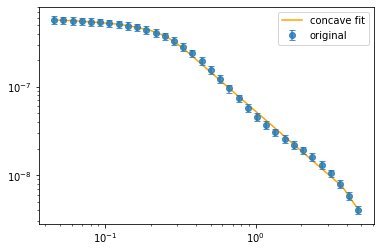

In [10]:
Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

Now let's try it with more realistic data. For that, we will copy the data from the Aeff_bkg_spline.ipynb

In [11]:
fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
EffA = pd.DataFrame(fileEA)
EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
EffaE= EffA['E [TeV]'].to_numpy()
Effa = EffA['Eff area (m^2)'].to_numpy()

#absorption file
file = np.loadtxt('tau_dominguez11.out')
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()

In [12]:
fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
Bkgpd = pd.DataFrame(fileBkg)
Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
BckgEdiff = BckgEmax - BckgEmin

BckgElogmean = []
for i in range(len(Bckg)):
    BckgElogmean.append(10**(np.mean([np.log10(BckgEmax[i]), np.log10(BckgEmin[i])])))


Ebinsmin = np.zeros(len(E))
Ebinsmax = np.zeros(len(E))

for i in range(1, len(E)):
    Ebinsmin[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i-1])]))
for i in range(len(E) - 1):
    Ebinsmax[i] = 10**(np.mean([np.log10(E[i]), np.log10(E[i+1])]))
    
Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
Ebinsmax[len(E)-1] = 10**(np.log10(Ebinsmax[len(E)-2])-(np.log10(Ebinsmax[len(E)-3])-np.log10(Ebinsmax[len(E)-2])))
Ebinsw = Ebinsmax - Ebinsmin

In [13]:
DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2
def log_interp1d(xx, yy):
    logx = np.log10(xx)
    logy = np.log10(yy)
    interp = interpolate.interp1d(logx, logy, fill_value='extrapolate', kind='slinear')
    log_interp = lambda zz: np.power(10.0, interp(np.log10(zz)))
    return log_interp

interpolation = log_interp1d(BckgElogmean,DifBckg)

In [14]:
def trapint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation(toplim) + interpolation(bottomlim)) / 2)

def sqint(toplim, bottomlim):
    return ((toplim - bottomlim) * (interpolation((toplim + bottomlim) / 2)))


In [15]:
newBckgrate = np.zeros([len(E[3:37]),2])
for i in range(len(E[3:37])):
    newBckgrate[i] = quad(interpolation, Ebinsmin[i+3], Ebinsmax[i+3])
newBckgrate = newBckgrate[:,0]

newlogBckg5 = trapint(Ebinsmax[3:37], Ebinsmin[3:37])

newlogBckg6 = sqint(Ebinsmax[3:37], Ebinsmin[3:37])

In [16]:
#“photon index  = 2.03  +/- 0.03 and normalization factor at 250 GeV    f0 = (8.70 +/- 0.17) * 10^-10 cm^-2  s^-1  TeV^-1.”
K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)

In [17]:
EffaA2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(EffaE[9:51])):
        if EffaE[j+9] < E[i+3] and EffaE[j+10] > E[i+3]:
            m = (Effa[j+10]-Effa[j+9])/(EffaE[j+10]-EffaE[j+9])
            n = Effa[j+9] - m * EffaE[j+9]
            EffaA2[i] = m * E[i+3] + n

In [18]:
fileAng = np.loadtxt('Angres.txt', skiprows = 11)
Angresall = pd.DataFrame(fileAng)
Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
AngresE= Angresall['E [TeV]'].to_numpy()
Angres = Angresall['Angular resolution (deg)'].to_numpy()

logAngres = np.log10(Angres)
logAngresE = np.log10(AngresE)
logE = np.log10(E)


logAngres2 = np.zeros(len(E[3:37]))
for i in range(len(E[3:37])):
    for j in range(len(AngresE[1:-1])):
        if logAngresE[j+1] < logE[i+3] and logAngresE[j+2] > logE[i+3]:
            m = (logAngres[j+2]-logAngres[j+1])/(logAngresE[j+2]-logAngresE[j+1])
            n = logAngres[j+1] - m * logAngresE[j+1]
            logAngres2[i] = m * logE[i+3] + n
Angres2 = 10**logAngres2

In [19]:
def degtorad(ang):
    return ang * np.pi / 180


time = 42480 #42480 #180000#s
skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(degtorad(Angres2)))#deg^2

bckgmu = newBckgrate * time * skyang

my_generator = np.random.default_rng(2021)
Simbckg1 = my_generator.poisson(bckgmu)
# Simbckg1 = bckgmu
Simbckg1 = Simbckg1.astype(float)
for i in range(len(Simbckg1)):
    if Simbckg1[i] == 0:
        Simbckg1[i] = bckgmu[i]
Simbckg1_u = np.sqrt(Simbckg1)
Simbckg5 = my_generator.poisson(5*bckgmu)/5
# Simbckg5 = 5*bckgmu/5
Simbckg5 = Simbckg5.astype(float)
for i in range(len(Simbckg5)):
    if Simbckg5[i] == 0:
        Simbckg5[i] = bckgmu[i]
Simbckg5_u = np.sqrt(Simbckg5)

In [20]:
mu = dNdEa[3:37] * EffaA2 * Ebinsw[3:37] * time 
N = my_generator.poisson(mu)
# N = mu

for i in range(len(N)):
    if N[i] == 0:
        N[i] = mu[i]
N_u = np.sqrt(N)
dNdE_p = dNdEa[3:37] * N/mu
dNdE_p_u = dNdEa[3:37] * 1/np.sqrt(N)

Simbckg = (Simbckg1 - Simbckg5) / EffaA2 / Ebinsw[3:37] / time
Simbckg_u = (Simbckg1_u + Simbckg5_u) / EffaA2 / Ebinsw[3:37] / time


dNdE_b = dNdE_p + Simbckg
dNdE_b_u = dNdE_p_u + Simbckg_u

In [21]:
SED = np.square(E[3:37]) * dNdE_b
SED_u = np.square(E[3:37]) * dNdE_b_u

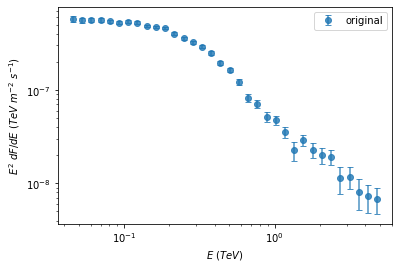

In [22]:
plt.errorbar(E[3:37], SED, label='original',yerr = SED_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

Okay, now let's test the new fitting method:

<ValueView x0=5.656440803306359e-07 x1=0.048740202454146675 x2=-0.5082128835433398 x3=-0.8992672697597098 x4=-0.7350644496887507 x5=-3.983620995107141e-05 x6=0.0>
<ErrorView x0=1.6709713338061027e-08 x1=0.04803560427296684 x2=0.06787622232745628 x3=0.030668570832464683 x4=0.044374920175150386 x5=0.1025308102090477 x6=0.20851869110167548>


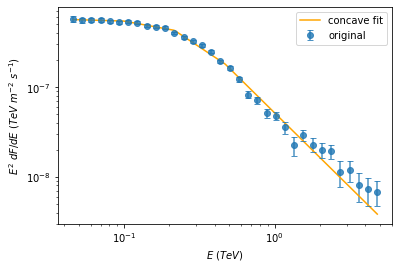

In [23]:
ydata = SED
xdata = E[3:37]
knots = 7
ydata_u = SED_u
initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$E$ ($TeV$)")
plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
plt.legend()
plt.show()

<ValueView x0=5.658822755662123e-07 x1=0.046896530194815 x2=-0.26906056105096104 x3=-0.43359542386483446 x4=-0.6291059603852536 x5=-0.8242359123662278 x6=-0.4621879804213088 x7=0.0018598231726045177 x8=0.0 x9=0.0 x10=-0.002899645483001853>
<ErrorView x0=1.6631918159463964e-08 x1=0.061236803691967025 x2=0.1404147188955614 x3=0.09389159774340265 x4=0.07305361456424946 x5=0.06566628824024831 x6=0.10312379942117646 x7=0.1118317113672853 x8=0.11476902479551511 x9=0.1758347659818785 x10=0.35233890959780145>
<ValueView x0=4.346200588018185e-07 x1=-1.3813630294337458 x2=-1.5149390076841063 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=5.018821963804599e-09 x1=0.01739726409647108 x2=0.0061227872346728595 x3=0.02381921760059672 x4=0.049840180765105 x5=1.4160823612535596 x6=0.04480581310354623 x7=0.02695474552800271 x8=0.021834454826465385 x9=0.019847999233577527 x10=0.018962139809093757>
<ValueView x0=5.470119534055545e-07 x1=-0.20476834715888315 x2=-0.744408823147806 x

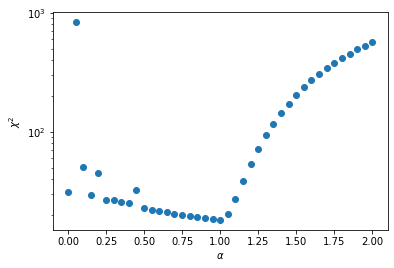

In [28]:
chisqs = []
alphas = []

for i in range(41):
    alpha = round(0.05 * i, 2)
    alphas.append(alpha)
    dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
    dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
    SED2 = np.square(E[3:37]) * dNdE2
    SED_u2 = np.square(E[3:37]) * dNdE2_u
    ydata = SED2
    xdata = E[3:37]
    knots =11
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
    chisqs.append(chi2)

plt.plot(alphas, chisqs, 'o')
plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()

<ValueView x0=5.696147278271429e-07 x1=0.03171438663033132 x2=-0.4514786881764247 x3=-0.4426535972861456 x4=-0.0004587619949935444 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.699139221364894e-07 x1=0.03149855456533118 x2=-0.43315301354876695 x3=-0.4216759786502269 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.702465970251097e-07 x1=0.03128030593538843 x2=-0.41407544055103673 x3=-0.39989003005193 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ValueView x0=5.705218898553459e-07 x1=0.03104900843796016 x2=-0.3941908323010789 x3=-0.376477712507152 x4=0.0002885900684328745 x5=0.0 x6=0.0 x7=0.0 x8=0.0 x9=0.0 x10=0.0>
<ErrorView x0=0.0 x1=0.0 x2=0.0 x3=0.0 x4=0.0 x5=0.0 x6=0.0 x7=0.0 x8=

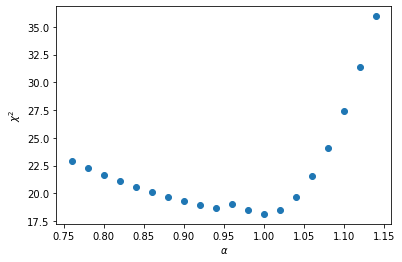

In [40]:
chisqs = []
alphas = []

for i in range(20):
    alpha = round(0.76 + 0.02 * i, 2)
    alphas.append(alpha)
    dNdE2 = dNdE_b * np.exp(alpha*tau[3:37])
    dNdE2_u = dNdE_b_u * np.exp(alpha*tau[3:37])
    SED2 = np.square(E[3:37]) * dNdE2
    SED_u2 = np.square(E[3:37]) * dNdE2_u
    ydata = SED2
    xdata = E[3:37]
    knots = 5
    ydata_u = SED_u2
    initial_guess = np.array([5e-7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #phi_0, lam1, deltas (len(deltas)=knots-2))
    things = multiple_bpl_fit(initial_guess=initial_guess)
    chi2 = chisq(SED2, multiple_bpl(E[3:37], things.values), SED_u2)
    chisqs.append(chi2)

plt.plot(alphas, chisqs, 'o')
#plt.yscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\chi^2$')
plt.show()